In [ ]:
# %% Cell 1: Import Libraries and Setup
##############################
# Telco Customer Churn Prediction - Enhanced Version
##############################

# Problem: Develop a machine learning model to predict customers likely to churn from a telecom company.
# This enhanced version includes advanced EDA visualizations, Optuna for hyperparameter tuning, and additional models.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
from optuna import Trial, study
import warnings
warnings.simplefilter(action="ignore")

# Set plot style for fancy visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# %% Cell 2: Load and Initial Data Inspection
df = pd.read_csv("Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric, handle errors
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Convert Churn to binary
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

print("Dataset Shape:", df.shape)
print("Data Types:\n", df.dtypes)
print("First 5 rows:\n", df.head())
print("Missing Values:\n", df.isnull().sum())

Dataset Shape: (7043, 21)
Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
First 5 rows:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  Churn
0  7590-VHVEG  Female              0     Yes       

In [3]:
# %% Cell 3: Enhanced EDA - General Overview
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include=[np.number]).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling          

In [4]:
# %% Cell 4: Variable Types and Analysis Functions
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


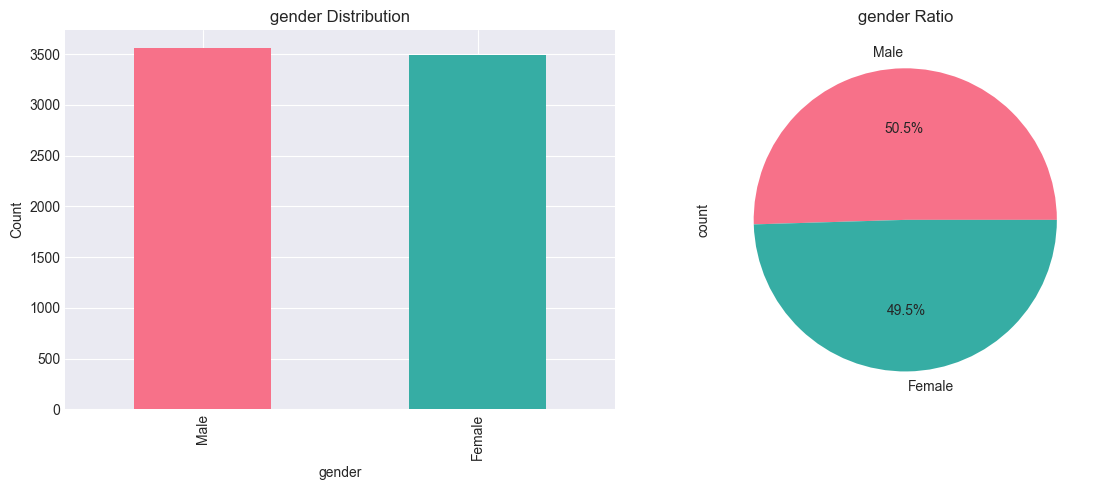

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


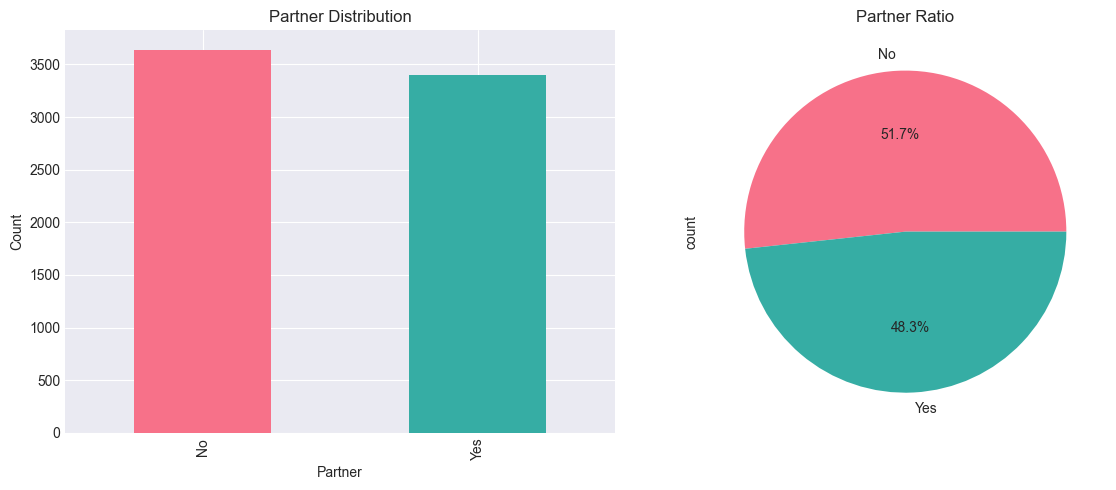

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


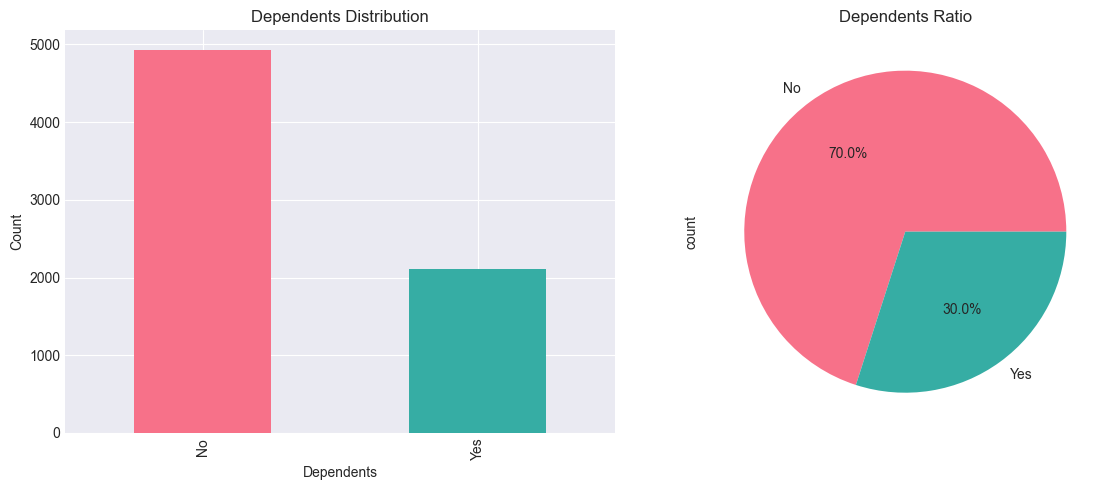

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


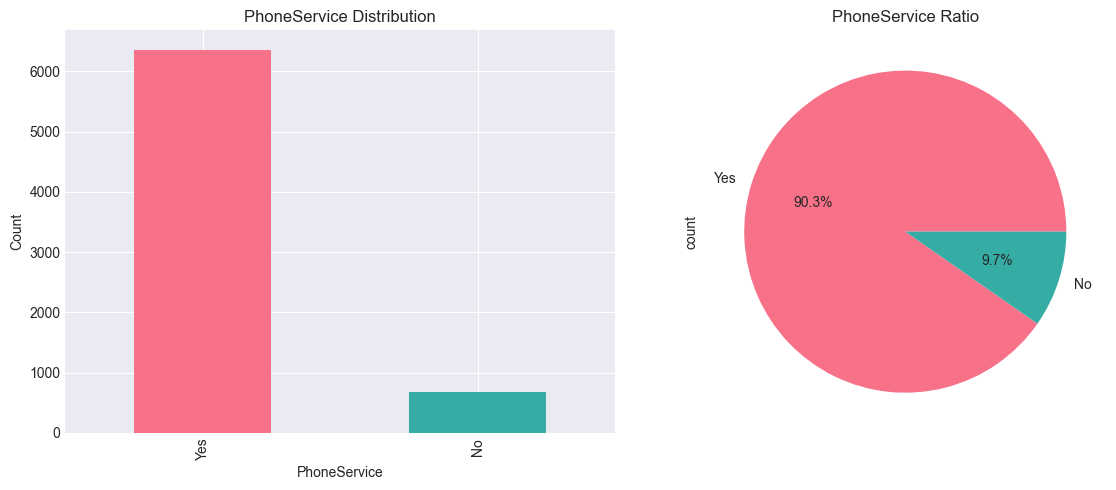

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


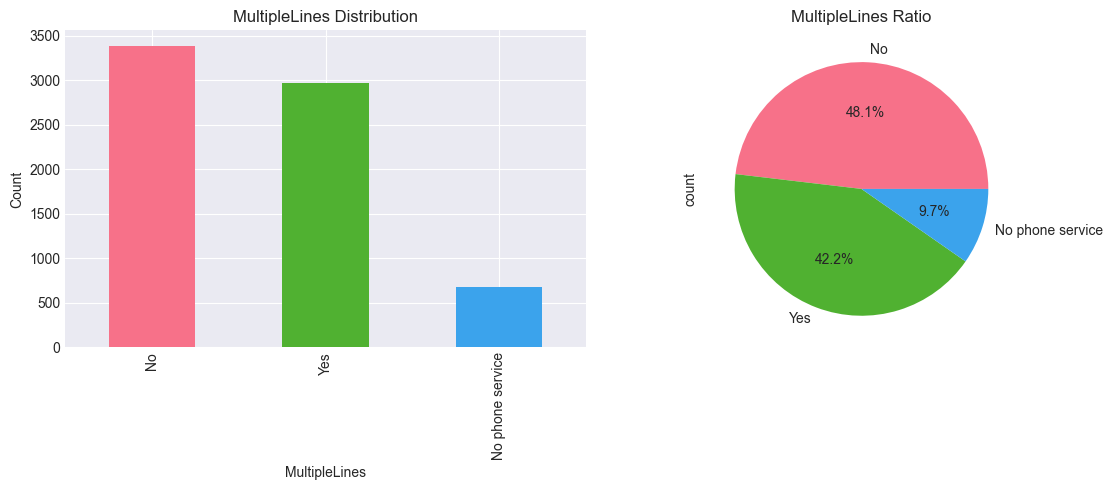

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


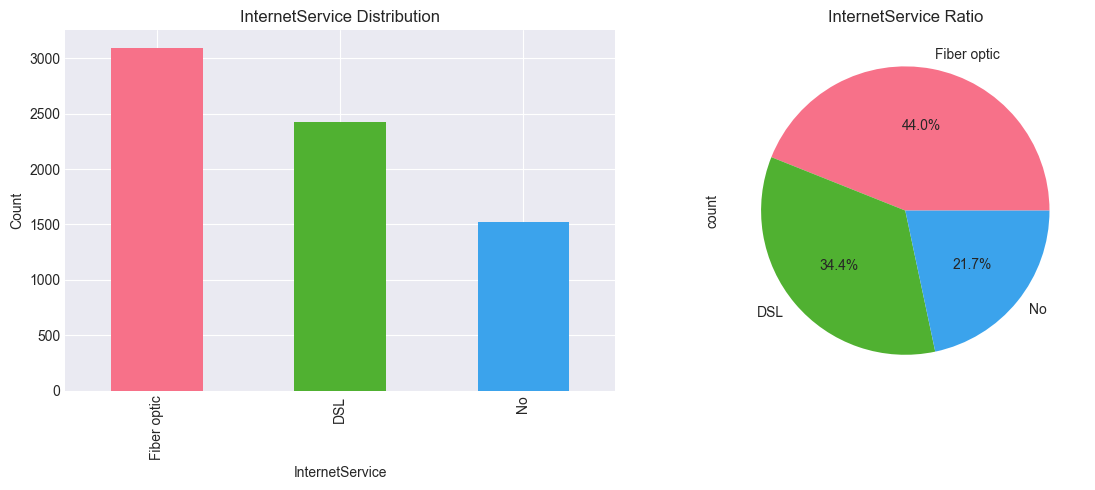

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


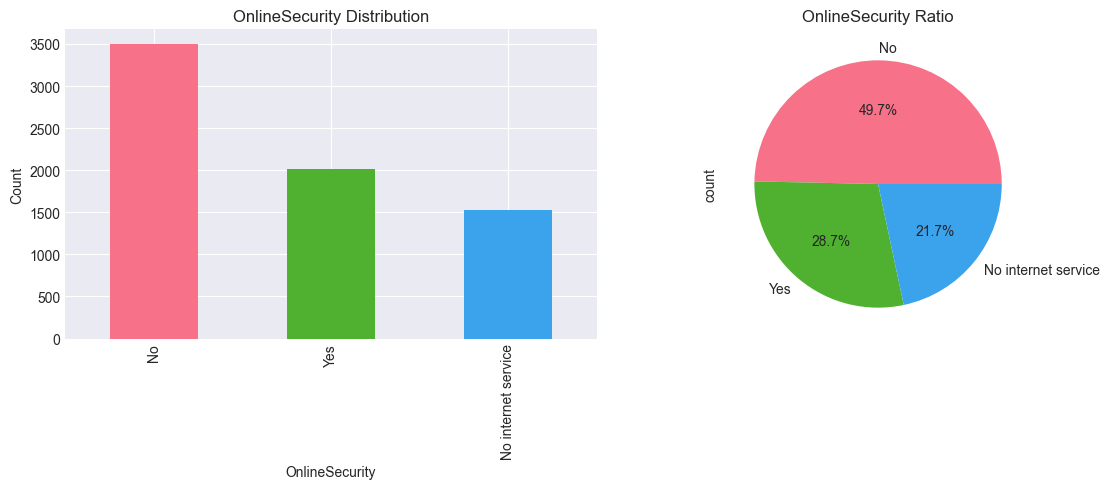

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


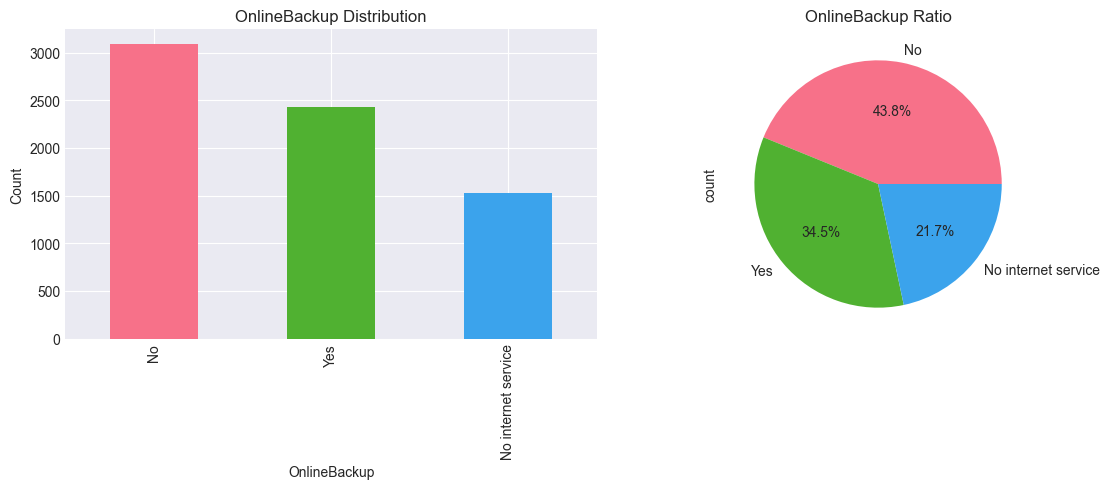

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


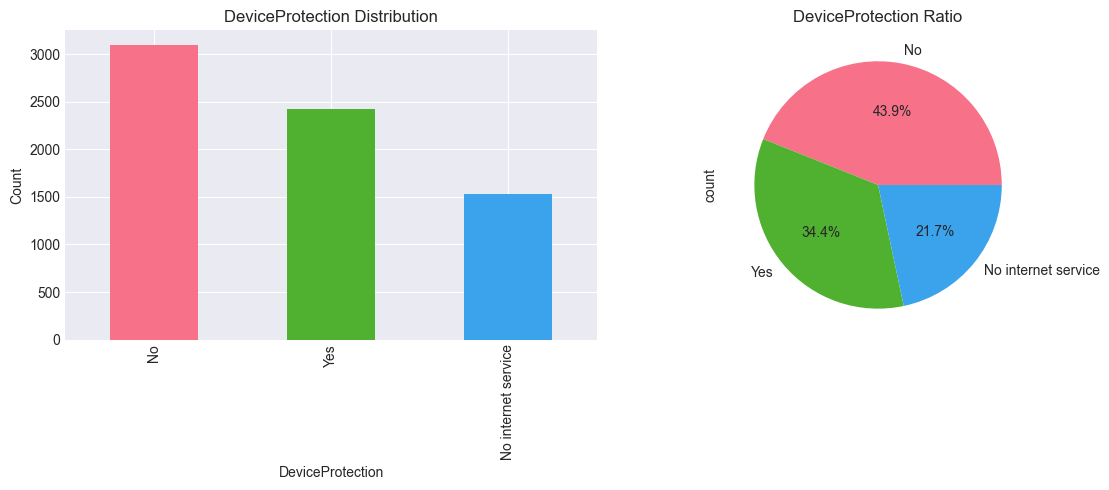

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


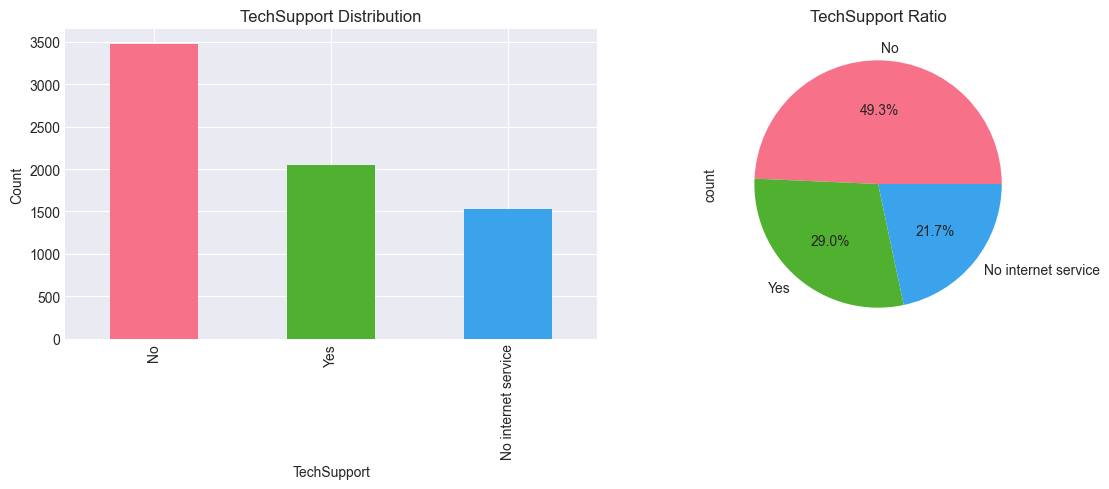

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


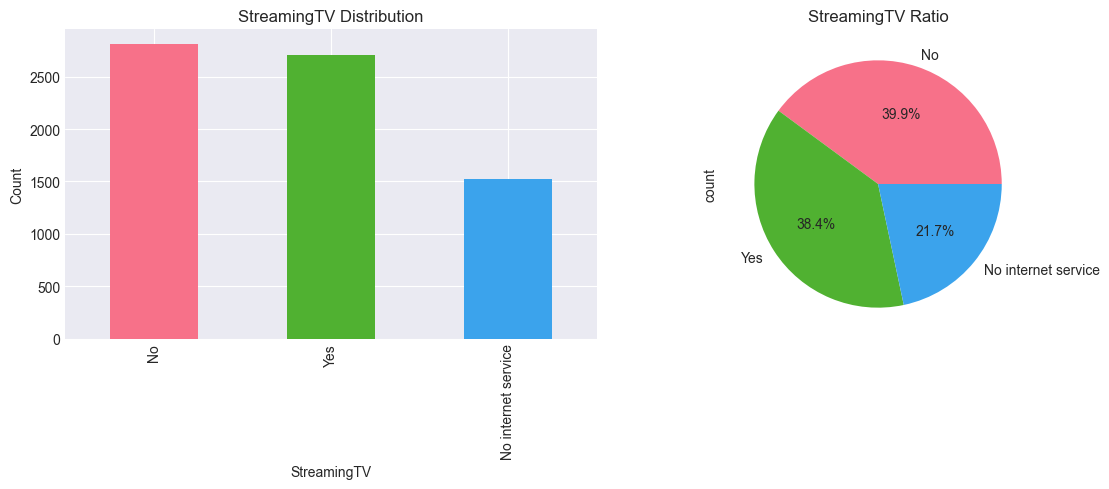

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


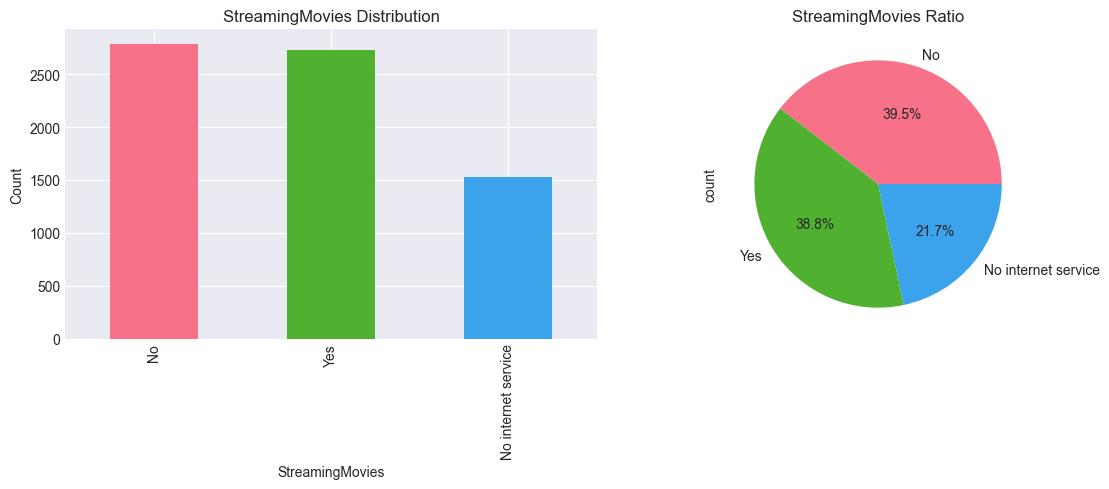

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


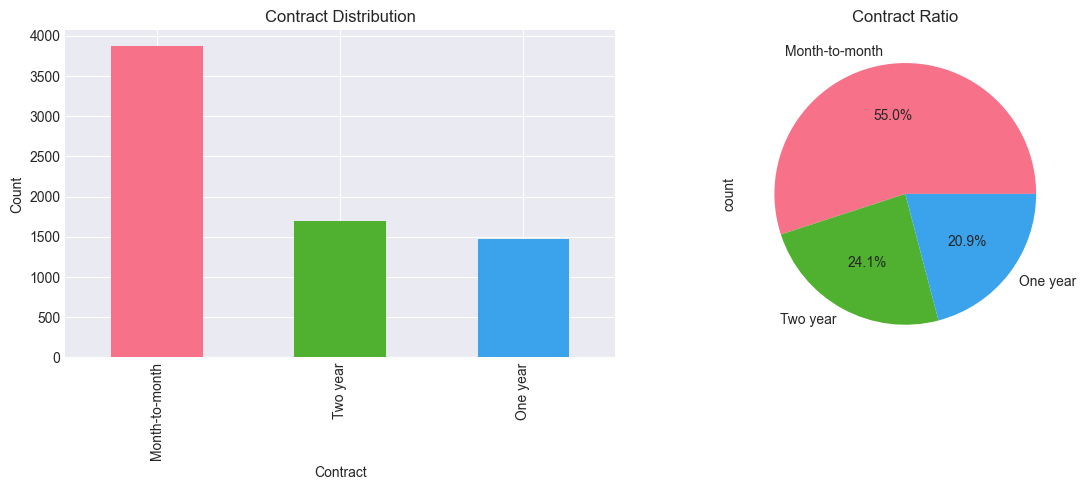

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


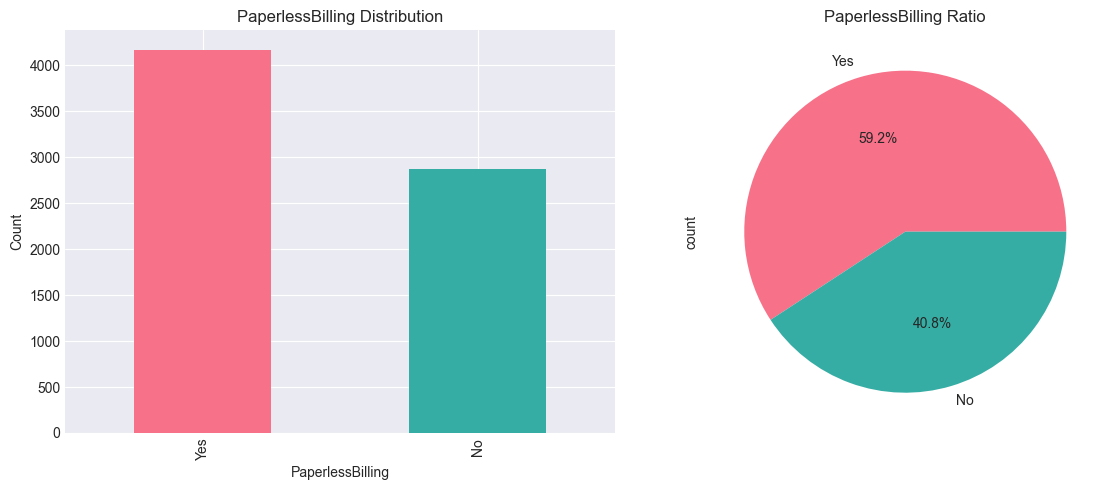

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


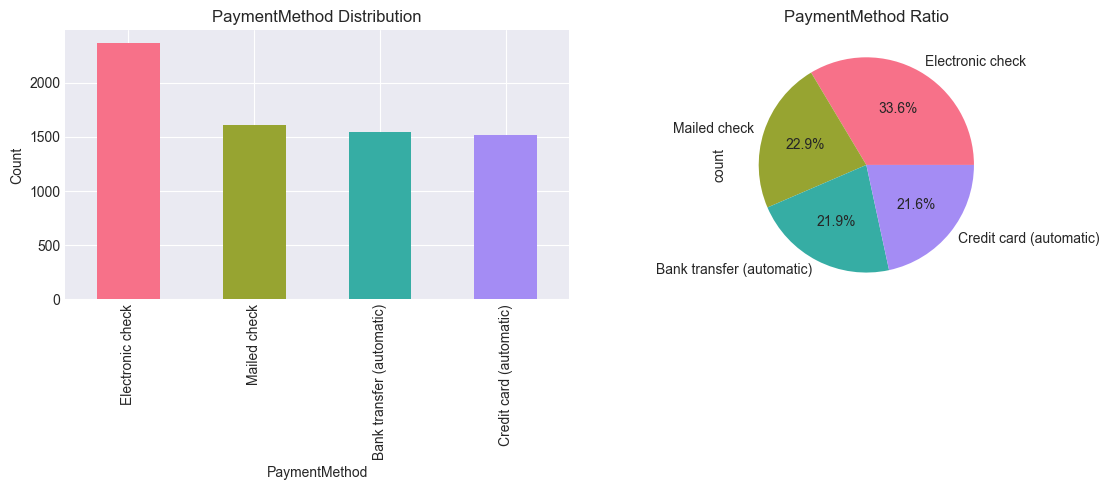

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


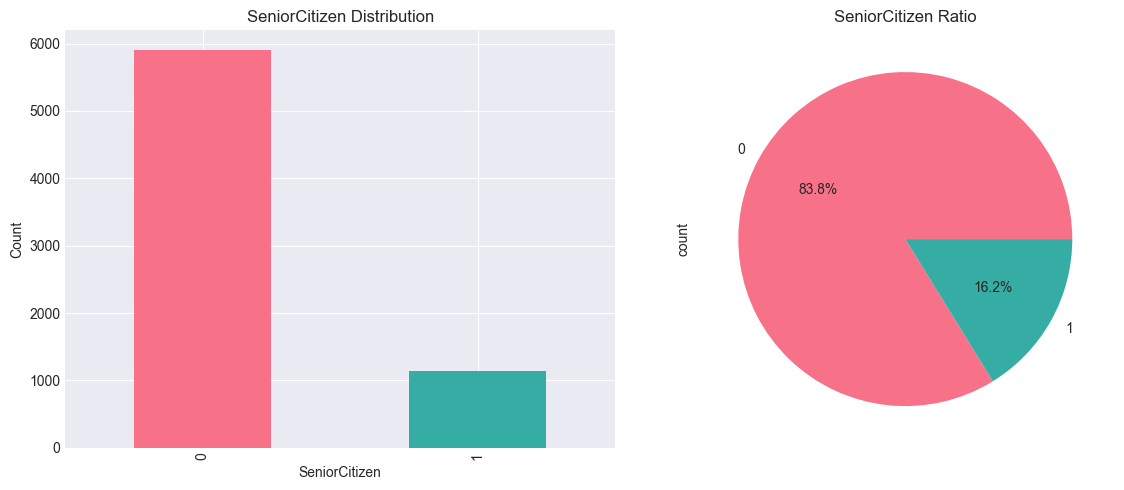

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
##########################################


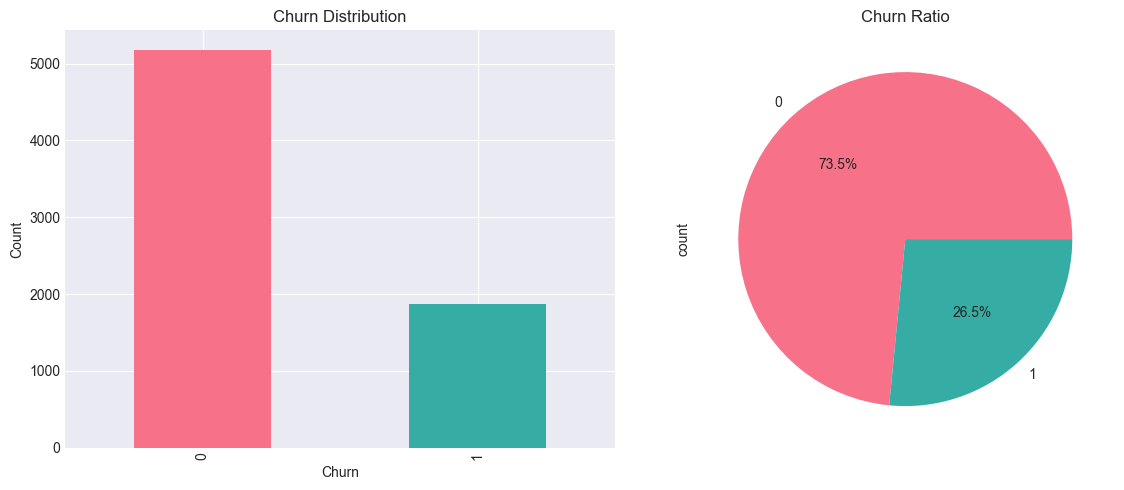

In [5]:
# %% Cell 5: Enhanced Categorical Variable Analysis
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        dataframe[col_name].value_counts().plot(kind='bar', ax=ax[0], color=sns.color_palette("husl", len(dataframe[col_name].unique())))
        ax[0].set_title(f'{col_name} Distribution')
        ax[0].set_ylabel('Count')
        dataframe[col_name].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=sns.color_palette("husl", len(dataframe[col_name].unique())))
        ax[1].set_title(f'{col_name} Ratio')
        plt.tight_layout()
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


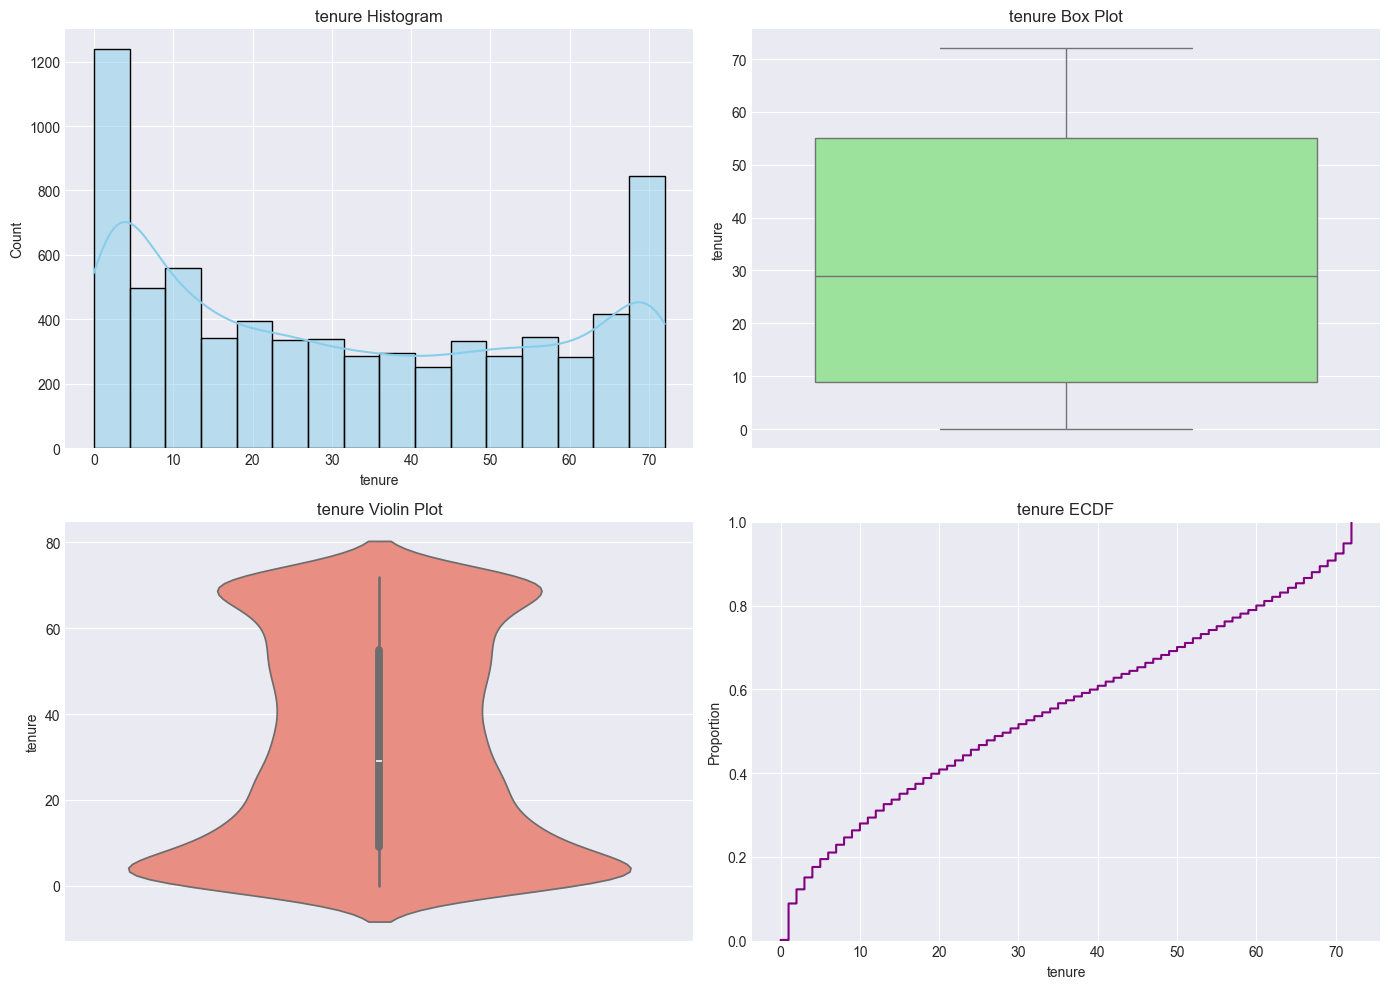

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


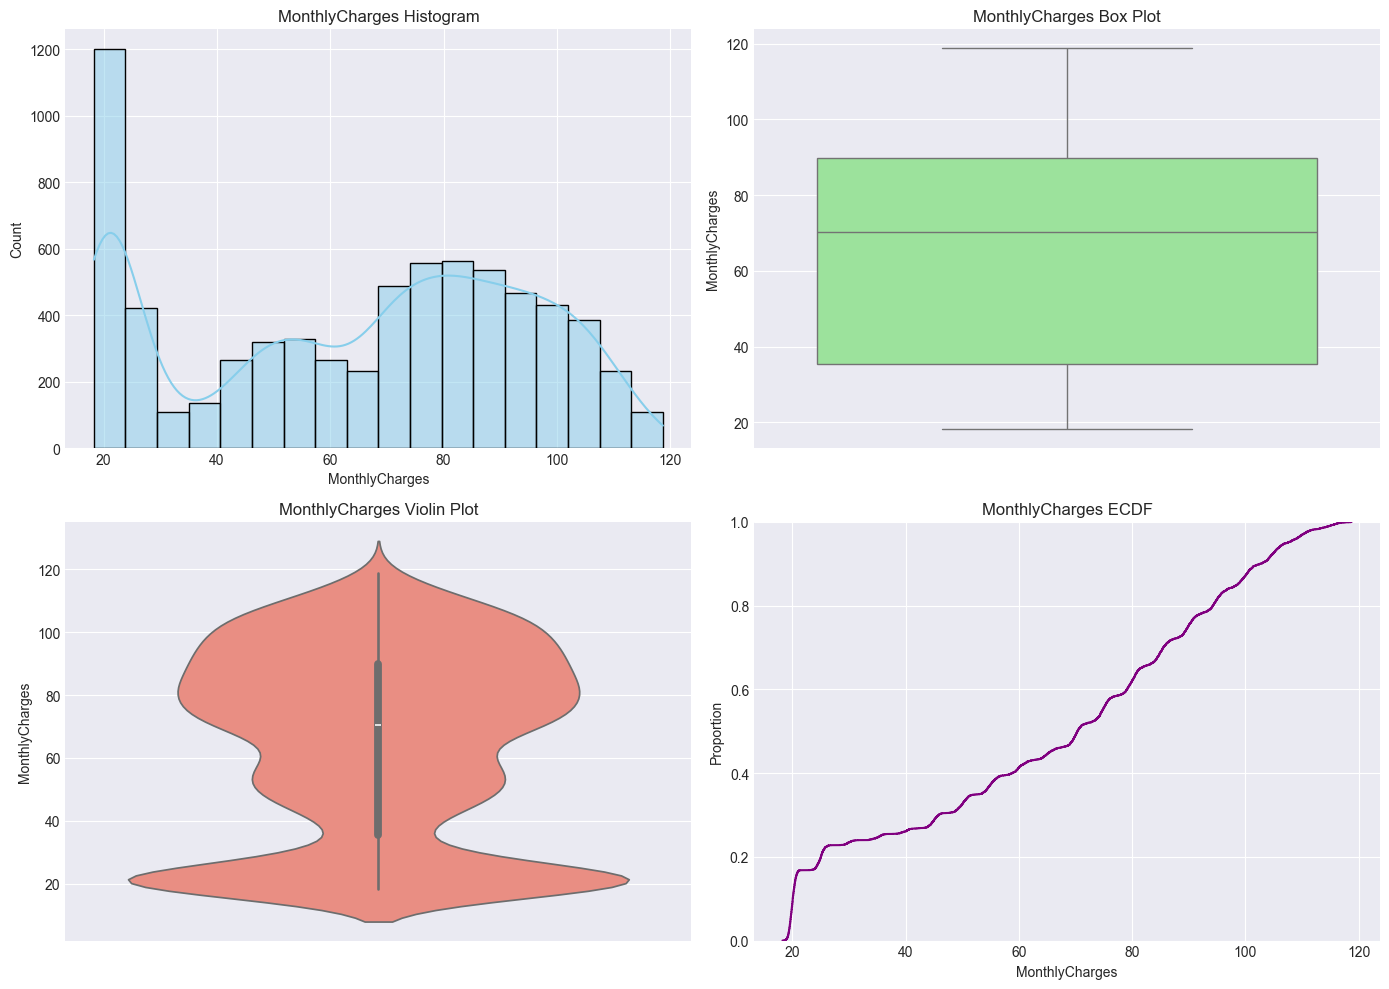

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


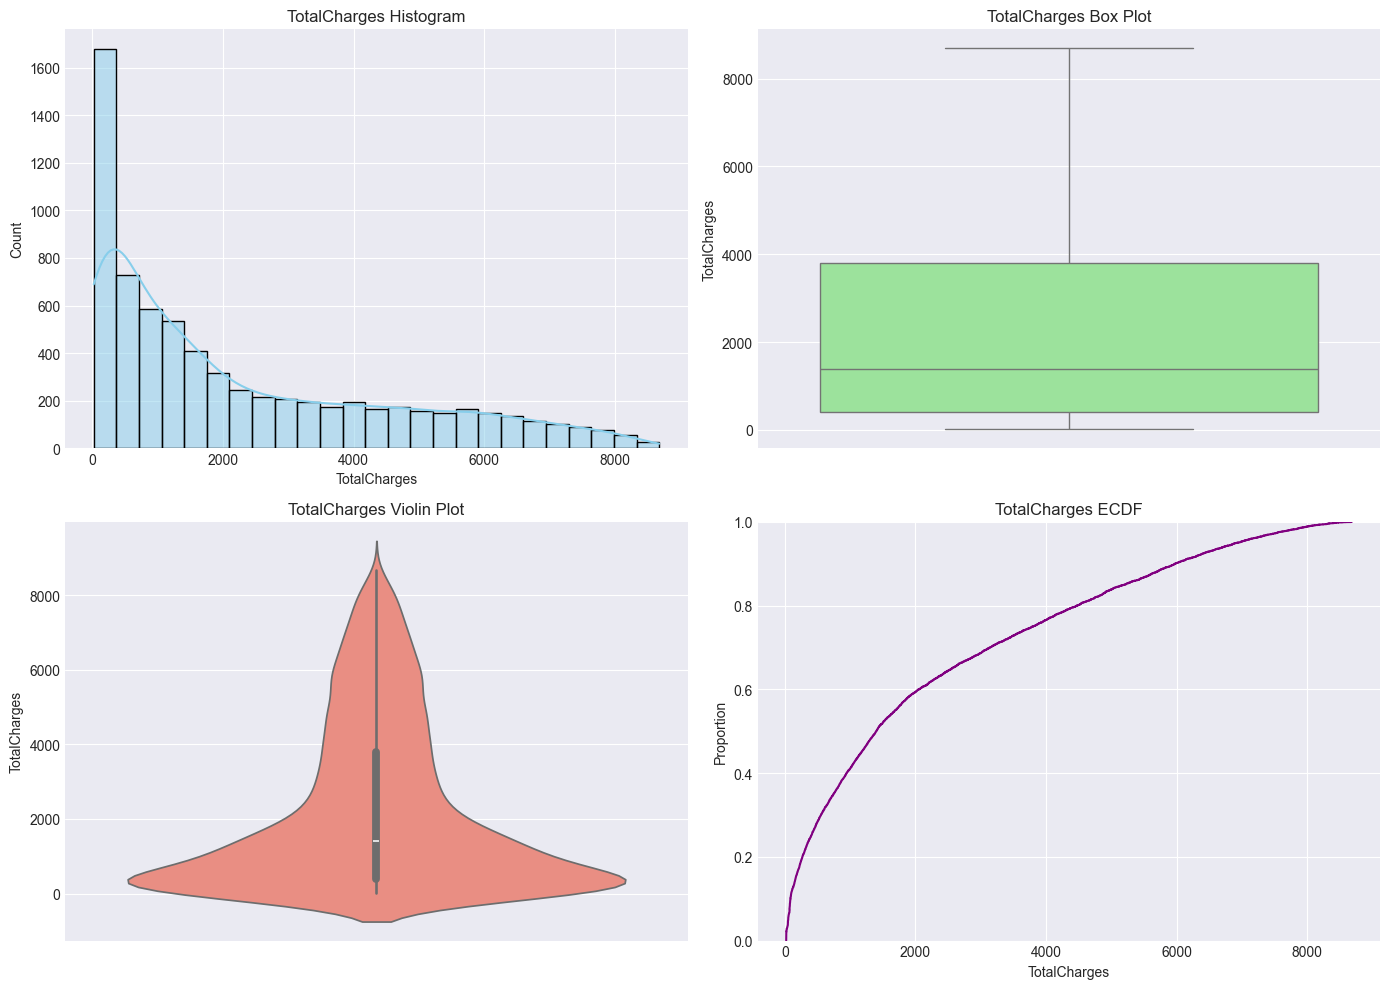

In [6]:
# %% Cell 6: Enhanced Numeric Variable Analysis
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(14, 10))

        # Histogram
        sns.histplot(dataframe[numerical_col], ax=ax[0,0], kde=True, color='skyblue')
        ax[0,0].set_title(f'{numerical_col} Histogram')

        # Box plot
        sns.boxplot(y=dataframe[numerical_col], ax=ax[0,1], color='lightgreen')
        ax[0,1].set_title(f'{numerical_col} Box Plot')

        # Violin plot
        sns.violinplot(y=dataframe[numerical_col], ax=ax[1,0], color='salmon')
        ax[1,0].set_title(f'{numerical_col} Violin Plot')

        # Cumulative distribution
        sns.ecdfplot(dataframe[numerical_col], ax=ax[1,1], color='purple')
        ax[1,1].set_title(f'{numerical_col} ECDF')

        plt.tight_layout()
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [7]:
# %% Cell 7: Target Variable Analysis
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796


gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3

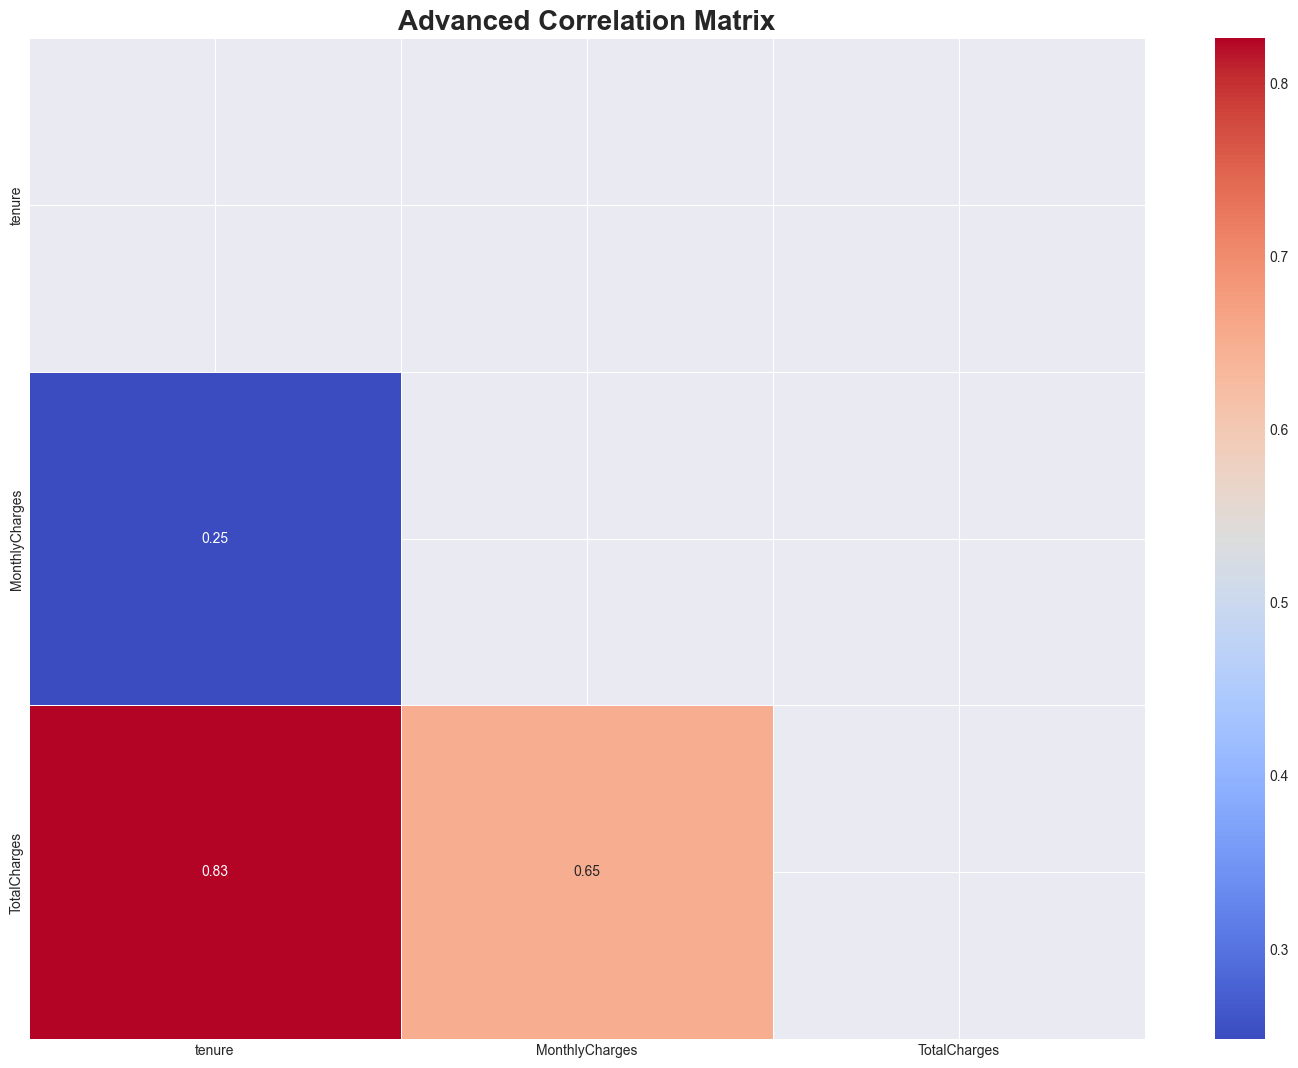

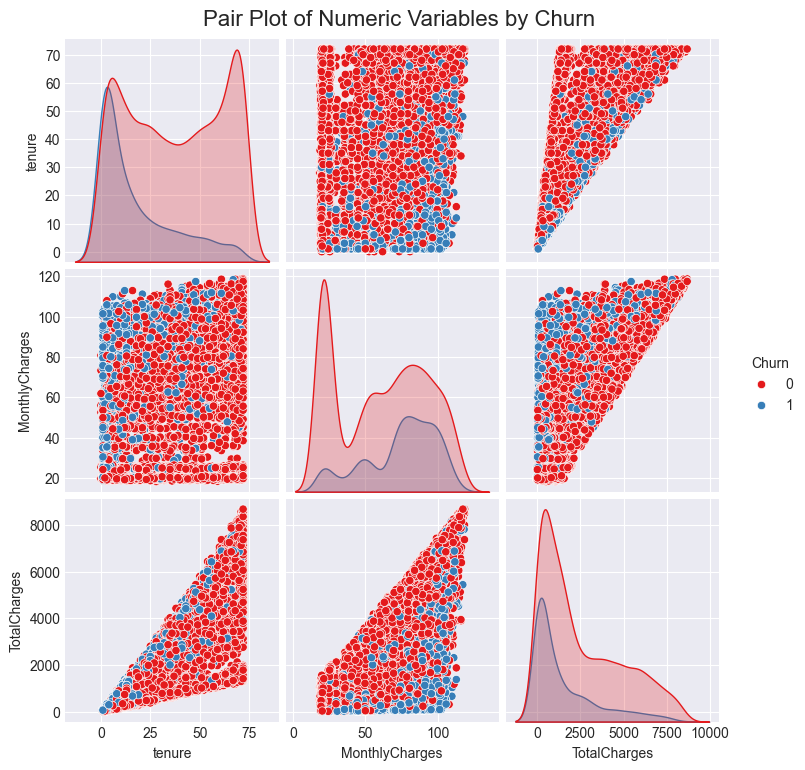

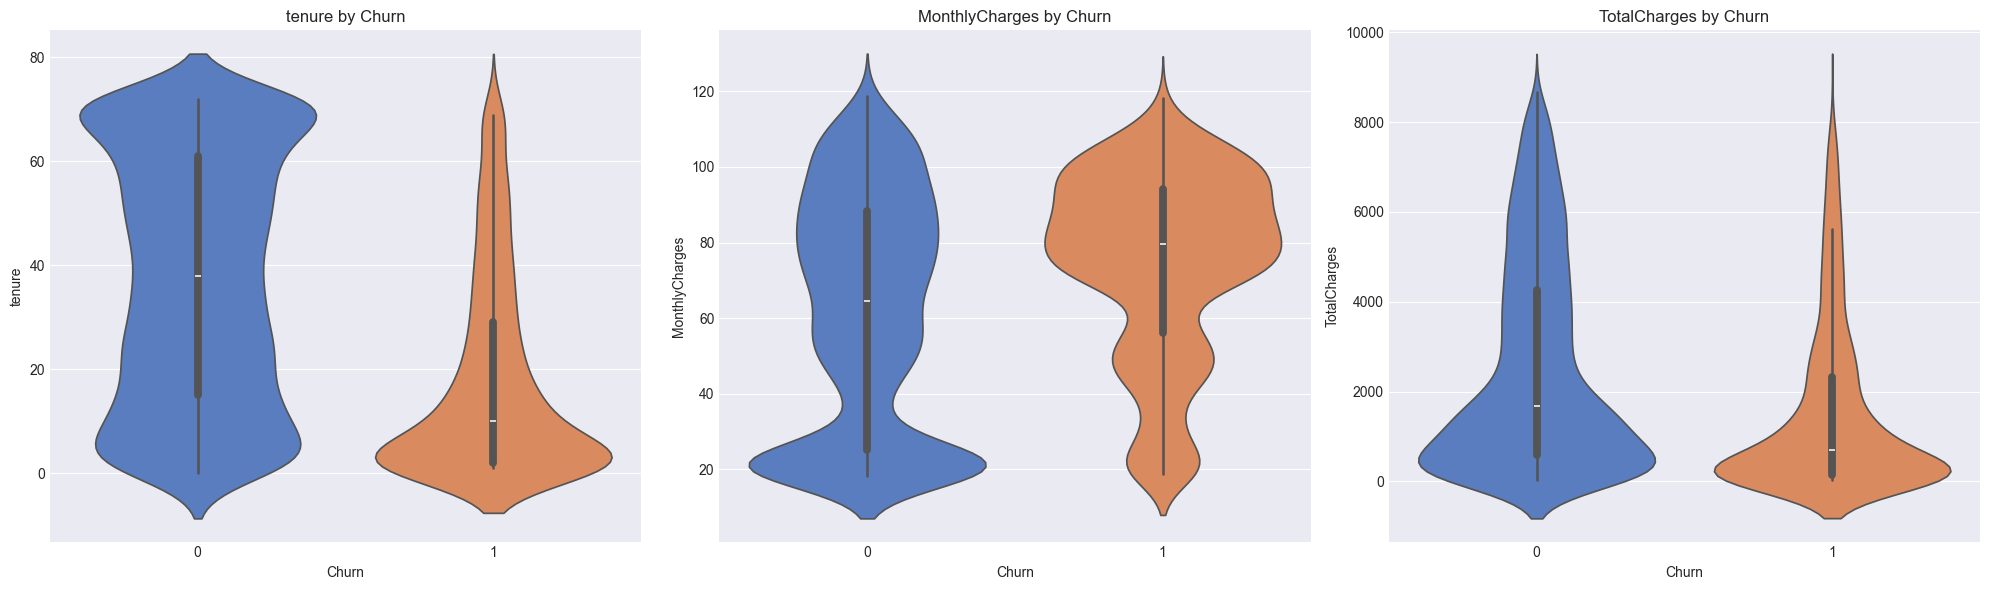

In [8]:
# %% Cell 8: Advanced Visualizations - Correlation and Relationships
# Correlation Matrix with enhanced heatmap
f, ax = plt.subplots(figsize=[18, 13])
mask = np.triu(np.ones_like(df[num_cols].corr(), dtype=bool))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="coolwarm", mask=mask, linewidths=.5)
ax.set_title("Advanced Correlation Matrix", fontsize=20, fontweight='bold')
plt.show()

# Pair plot for numeric variables colored by Churn
sns.pairplot(df[num_cols + ['Churn']], hue='Churn', palette='Set1', diag_kind='kde')
plt.suptitle('Pair Plot of Numeric Variables by Churn', y=1.02, fontsize=16)
plt.show()

# Violin plots for numeric variables by Churn
fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 6))
for i, col in enumerate(num_cols):
    sns.violinplot(x='Churn', y=col, data=df, ax=axes[i], palette='muted')
    axes[i].set_title(f'{col} by Churn')
plt.tight_layout()
plt.show()

In [9]:
# %% Cell 9: Missing Values and Outlier Handling
# Fill missing TotalCharges with MonthlyCharges
df.iloc[df[df["TotalCharges"].isnull()].index, df.columns.get_loc('TotalCharges')] = df[df["TotalCharges"].isnull()]["MonthlyCharges"]

# Tenure adjustment
df["tenure"] = df["tenure"] + 1

# Outlier handling
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [10]:
# %% Cell 10: Feature Engineering
# Tenure year categories
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

# Engaged customers
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

# No protection
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Young not engaged
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

# Total services
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

# Any streaming
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Auto payment
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# Average charges
df["NEW_AVG_Charges"] = df["TotalCharges"] / df["tenure"]

# Increase
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Service fee per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [11]:
# %% Cell 11: Encoding
cat_cols, num_cols, cat_but_car = grab_col_names(df)

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


In [12]:
# %% Cell 12: Scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])



In [13]:
# %% Cell 13: Base Model Training
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## LR ##########
Accuracy: 0.8069
Auc: 0.8503
Recall: 0.5388
Precision: 0.6704
F1: 0.5968
########## KNN ##########
Accuracy: 0.7718
Auc: 0.781
Recall: 0.5276
Precision: 0.577
F1: 0.5508
########## CART ##########
Accuracy: 0.7299
Auc: 0.6596
Recall: 0.5056
Precision: 0.4917
F1: 0.4984
########## RF ##########
Accuracy: 0.7931
Auc: 0.8267
Recall: 0.5056
Precision: 0.6401
F1: 0.5648
########## XGB ##########
Accuracy: 0.7877
Auc: 0.8244
Recall: 0.5094
Precision: 0.6231
F1: 0.5602
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 6338, number of used features: 44
[LightG

In [14]:
# %% Cell 14: Optuna Hyperparameter Tuning
# Random Forest
def rf_objective(trial):
    max_depth = trial.suggest_int("max_depth", 5, 50)
    max_features = trial.suggest_categorical("max_features", [3, 5, 7, "sqrt", None])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    model = RandomForestClassifier(max_depth=max_depth, max_features=max_features,
                                   min_samples_split=min_samples_split, n_estimators=n_estimators, random_state=17)
    cv_results = cross_validate(model, X, y, cv=5, scoring="roc_auc")
    return cv_results['test_score'].mean()

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=50)
rf_best_params = rf_study.best_params
rf_final = RandomForestClassifier(**rf_best_params, random_state=17).fit(X, y)

# XGBoost
def xgb_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth,
                          n_estimators=n_estimators, colsample_bytree=colsample_bytree, random_state=17)
    cv_results = cross_validate(model, X, y, cv=5, scoring="roc_auc")
    return cv_results['test_score'].mean()

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=50)
xgb_best_params = xgb_study.best_params
xgb_final = XGBClassifier(**xgb_best_params, random_state=17).fit(X, y)

# LightGBM
def lgbm_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    num_leaves = trial.suggest_int("num_leaves", 20, 100)
    model = LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators,
                           colsample_bytree=colsample_bytree, num_leaves=num_leaves, random_state=17)
    cv_results = cross_validate(model, X, y, cv=5, scoring="roc_auc")
    return cv_results['test_score'].mean()

lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(lgbm_objective, n_trials=50)
lgbm_best_params = lgbm_study.best_params
lgbm_final = LGBMClassifier(**lgbm_best_params, random_state=17).fit(X, y)

# CatBoost
def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 200, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    depth = trial.suggest_int("depth", 3, 10)
    model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate,
                               depth=depth, verbose=False, random_state=17)
    cv_results = cross_validate(model, X, y, cv=5, scoring="roc_auc")
    return cv_results['test_score'].mean()

catboost_study = optuna.create_study(direction="maximize")
catboost_study.optimize(catboost_objective, n_trials=50)
catboost_best_params = catboost_study.best_params
catboost_final = CatBoostClassifier(**catboost_best_params, verbose=False, random_state=17).fit(X, y)

[I 2025-09-29 02:16:04,902] A new study created in memory with name: no-name-774087fd-047c-4564-bf81-7d2b15ce1437
[I 2025-09-29 02:16:11,050] Trial 0 finished with value: 0.8430097532072198 and parameters: {'max_depth': 6, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 380}. Best is trial 0 with value: 0.8430097532072198.
[I 2025-09-29 02:16:17,402] Trial 1 finished with value: 0.8326609074913328 and parameters: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 173}. Best is trial 0 with value: 0.8430097532072198.
[I 2025-09-29 02:16:31,126] Trial 2 finished with value: 0.8415560650998151 and parameters: {'max_depth': 5, 'max_features': 3, 'min_samples_split': 13, 'n_estimators': 927}. Best is trial 0 with value: 0.8430097532072198.
[I 2025-09-29 02:16:34,572] Trial 3 finished with value: 0.8415708118909085 and parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_split': 19, 'n_estimators': 111}. Best is trial 0 with value: 0.84

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:13,237] Trial 0 finished with value: 0.8154725613546405 and parameters: {'learning_rate': 0.24193579754491082, 'n_estimators': 217, 'colsample_bytree': 0.9000138543163649, 'num_leaves': 24}. Best is trial 0 with value: 0.8154725613546405.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:14,972] Trial 1 finished with value: 0.8207886962964853 and parameters: {'learning_rate': 0.16869299235472696, 'n_estimators': 440, 'colsample_bytree': 0.5644587491909705, 'num_leaves': 22}. Best is trial 1 with value: 0.8207886962964853.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-09-29 02:35:22,744] Trial 2 finished with value: 0.8027968428765819 and parameters: {'learning_rate': 0.27564930683960165, 'n_estimators': 743, 'colsample_bytree': 0.5166953129432758, 'num_leaves': 96}. Best is trial 1 with value: 0.8207886962964853.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-29 02:35:25,479] Trial 3 finished with value: 0.838128283987649 and parameters: {'learning_rate': 0.015770940673528622, 'n_estimators': 335, 'colsample_bytree': 0.7406519625648796, 'num_leaves': 48}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:28,375] Trial 4 finished with value: 0.8104340095416325 and parameters: {'learning_rate': 0.1871847468592231, 'n_estimators': 466, 'colsample_bytree': 0.9699230247545433, 'num_leaves': 38}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:34,102] Trial 5 finished with value: 0.8203695362067123 and parameters: {'learning_rate': 0.06881456927702916, 'n_estimators': 693, 'colsample_bytree': 0.5949863403942541, 'num_leaves': 55}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:35,360] Trial 6 finished with value: 0.8101872954587506 and parameters: {'learning_rate': 0.28111829302723257, 'n_estimators': 268, 'colsample_bytree': 0.8859632772376249, 'num_leaves': 26}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:38,819] Trial 7 finished with value: 0.8255670680777103 and parameters: {'learning_rate': 0.05082623579668637, 'n_estimators': 274, 'colsample_bytree': 0.7151359207338324, 'num_leaves': 87}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:43,554] Trial 8 finished with value: 0.8068482745249984 and parameters: {'learning_rate': 0.2591988408931284, 'n_estimators': 573, 'colsample_bytree': 0.7703838888966761, 'num_leaves': 55}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:46,758] Trial 9 finished with value: 0.8315319220521266 and parameters: {'learning_rate': 0.03226128204122335, 'n_estimators': 713, 'colsample_bytree': 0.7685224734618197, 'num_leaves': 26}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:35:57,035] Trial 10 finished with value: 0.811688362103815 and parameters: {'learning_rate': 0.10718560507529006, 'n_estimators': 958, 'colsample_bytree': 0.6643258750078441, 'num_leaves': 72}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:36:03,278] Trial 11 finished with value: 0.8356017845968683 and parameters: {'learning_rate': 0.010873445785898491, 'n_estimators': 876, 'colsample_bytree': 0.7973914848439586, 'num_leaves': 42}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:10,246] Trial 12 finished with value: 0.8349735755350473 and parameters: {'learning_rate': 0.010622995197335842, 'n_estimators': 992, 'colsample_bytree': 0.8320856686573019, 'num_leaves': 40}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:36:16,244] Trial 13 finished with value: 0.814617383606954 and parameters: {'learning_rate': 0.10281946030549632, 'n_estimators': 837, 'colsample_bytree': 0.6734022960605472, 'num_leaves': 46}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:20,208] Trial 14 finished with value: 0.8196163168133903 and parameters: {'learning_rate': 0.08904005914790407, 'n_estimators': 385, 'colsample_bytree': 0.8165361611847226, 'num_leaves': 70}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:25,609] Trial 15 finished with value: 0.8138864589133927 and parameters: {'learning_rate': 0.14106510702910785, 'n_estimators': 543, 'colsample_bytree': 0.700498942827938, 'num_leaves': 66}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:26,694] Trial 16 finished with value: 0.8380620564320498 and parameters: {'learning_rate': 0.03724705296227018, 'n_estimators': 117, 'colsample_bytree': 0.9950765736507639, 'num_leaves': 47}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:27,605] Trial 17 finished with value: 0.826330699592701 and parameters: {'learning_rate': 0.13660931321350975, 'n_estimators': 102, 'colsample_bytree': 0.9654733733442629, 'num_leaves': 49}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:29,022] Trial 18 finished with value: 0.831819369620915 and parameters: {'learning_rate': 0.04972344645648581, 'n_estimators': 113, 'colsample_bytree': 0.8870425224646724, 'num_leaves': 79}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:30,854] Trial 19 finished with value: 0.8157352619665801 and parameters: {'learning_rate': 0.21380640652329677, 'n_estimators': 342, 'colsample_bytree': 0.6252127595083049, 'num_leaves': 32}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:36:32,841] Trial 20 finished with value: 0.8238421985406008 and parameters: {'learning_rate': 0.08373537620076932, 'n_estimators': 187, 'colsample_bytree': 0.9891696905124334, 'num_leaves': 61}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:37,095] Trial 21 finished with value: 0.8365290371912278 and parameters: {'learning_rate': 0.013517090899585705, 'n_estimators': 576, 'colsample_bytree': 0.8299531766033995, 'num_leaves': 45}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:41,676] Trial 22 finished with value: 0.8274793797308508 and parameters: {'learning_rate': 0.0362065416977237, 'n_estimators': 559, 'colsample_bytree': 0.856886746031532, 'num_leaves': 53}. Best is trial 3 with value: 0.838128283987649.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:44,023] Trial 23 finished with value: 0.8415688561760538 and parameters: {'learning_rate': 0.01042631520387184, 'n_estimators': 337, 'colsample_bytree': 0.9219266309730524, 'num_leaves': 36}. Best is trial 23 with value: 0.8415688561760538.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:45,736] Trial 24 finished with value: 0.8289626311099457 and parameters: {'learning_rate': 0.06268717475501642, 'n_estimators': 295, 'colsample_bytree': 0.9416153759916613, 'num_leaves': 33}. Best is trial 23 with value: 0.8415688561760538.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:46,723] Trial 25 finished with value: 0.841899151267814 and parameters: {'learning_rate': 0.029154549521324347, 'n_estimators': 153, 'colsample_bytree': 0.9413728625669606, 'num_leaves': 31}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:47,973] Trial 26 finished with value: 0.8412822178372881 and parameters: {'learning_rate': 0.02956895259802471, 'n_estimators': 188, 'colsample_bytree': 0.9302122299794375, 'num_leaves': 34}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:49,108] Trial 27 finished with value: 0.8256040802451468 and parameters: {'learning_rate': 0.11487976146012956, 'n_estimators': 180, 'colsample_bytree': 0.9215187960245473, 'num_leaves': 33}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:50,506] Trial 28 finished with value: 0.8306918969359819 and parameters: {'learning_rate': 0.06654390910027491, 'n_estimators': 220, 'colsample_bytree': 0.9357096598348112, 'num_leaves': 36}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:36:51,666] Trial 29 finished with value: 0.8303624620261785 and parameters: {'learning_rate': 0.08417213446230279, 'n_estimators': 220, 'colsample_bytree': 0.8691411174946939, 'num_leaves': 29}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:53,217] Trial 30 finished with value: 0.8118618824551607 and parameters: {'learning_rate': 0.21662550186981155, 'n_estimators': 422, 'colsample_bytree': 0.9166140311540343, 'num_leaves': 20}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:55,503] Trial 31 finished with value: 0.8348293625858277 and parameters: {'learning_rate': 0.026961297183115098, 'n_estimators': 334, 'colsample_bytree': 0.9547204378935646, 'num_leaves': 39}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:36:56,521] Trial 32 finished with value: 0.8384232950471479 and parameters: {'learning_rate': 0.05025660488769, 'n_estimators': 177, 'colsample_bytree': 0.7412179094736709, 'num_leaves': 30}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:57,443] Trial 33 finished with value: 0.8395411828164177 and parameters: {'learning_rate': 0.051134875560213136, 'n_estimators': 195, 'colsample_bytree': 0.8600533203412395, 'num_leaves': 23}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:58,506] Trial 34 finished with value: 0.8415209086490055 and parameters: {'learning_rate': 0.03479938755903045, 'n_estimators': 232, 'colsample_bytree': 0.9089023729393164, 'num_leaves': 22}. Best is trial 25 with value: 0.841899151267814.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:36:59,722] Trial 35 finished with value: 0.8428916401733053 and parameters: {'learning_rate': 0.028936276477128445, 'n_estimators': 253, 'colsample_bytree': 0.9061342582262142, 'num_leaves': 21}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:01,661] Trial 36 finished with value: 0.8154636106267205 and parameters: {'learning_rate': 0.17713306734171835, 'n_estimators': 501, 'colsample_bytree': 0.9011974446529403, 'num_leaves': 20}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:37:03,491] Trial 37 finished with value: 0.8304838452327703 and parameters: {'learning_rate': 0.07285272282509703, 'n_estimators': 373, 'colsample_bytree': 0.5078018808920368, 'num_leaves': 26}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:04,952] Trial 38 finished with value: 0.8414422597710166 and parameters: {'learning_rate': 0.02176229368678456, 'n_estimators': 260, 'colsample_bytree': 0.9736764950109881, 'num_leaves': 28}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:06,348] Trial 39 finished with value: 0.8366496971654293 and parameters: {'learning_rate': 0.043514304354339485, 'n_estimators': 312, 'colsample_bytree': 0.9051742374476418, 'num_leaves': 23}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:07,380] Trial 40 finished with value: 0.837249773324545 and parameters: {'learning_rate': 0.05746603251865304, 'n_estimators': 248, 'colsample_bytree': 0.8811497432519515, 'num_leaves': 20}. Best is trial 35 with value: 0.8428916401733053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:08,313] Trial 41 finished with value: 0.843333704033639 and parameters: {'learning_rate': 0.02369316038799485, 'n_estimators': 143, 'colsample_bytree': 0.978013339580974, 'num_leaves': 28}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:09,163] Trial 42 finished with value: 0.8427706854142862 and parameters: {'learning_rate': 0.02656142581526218, 'n_estimators': 144, 'colsample_bytree': 0.9521390663323112, 'num_leaves': 25}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:37:10,129] Trial 43 finished with value: 0.8429936590634008 and parameters: {'learning_rate': 0.02631776483907527, 'n_estimators': 146, 'colsample_bytree': 0.9485941312794524, 'num_leaves': 27}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:11,051] Trial 44 finished with value: 0.8430259953914992 and parameters: {'learning_rate': 0.02435012818973903, 'n_estimators': 150, 'colsample_bytree': 0.9560893364691612, 'num_leaves': 26}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Nu

[I 2025-09-29 02:37:11,930] Trial 45 finished with value: 0.841904121792836 and parameters: {'learning_rate': 0.04071037087834725, 'n_estimators': 138, 'colsample_bytree': 0.9991363653678335, 'num_leaves': 28}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:12,798] Trial 46 finished with value: 0.8354390717584337 and parameters: {'learning_rate': 0.07176568378869513, 'n_estimators': 153, 'colsample_bytree': 0.970192547570146, 'num_leaves': 26}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:15,130] Trial 47 finished with value: 0.8325252131558608 and parameters: {'learning_rate': 0.021281109459811594, 'n_estimators': 148, 'colsample_bytree': 0.9557334975493977, 'num_leaves': 97}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:17,132] Trial 48 finished with value: 0.8281882139865262 and parameters: {'learning_rate': 0.06068712553638321, 'n_estimators': 277, 'colsample_bytree': 0.9714343090049455, 'num_leaves': 42}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used featu

[I 2025-09-29 02:37:17,720] Trial 49 finished with value: 0.8375989440783792 and parameters: {'learning_rate': 0.09755420603424958, 'n_estimators': 101, 'colsample_bytree': 0.7885905269620319, 'num_leaves': 25}. Best is trial 41 with value: 0.843333704033639.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5635, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265306 -> initscore=-1.018570
[LightGBM] [Info] Start training from score -1.018570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 7043, number of used featu

[I 2025-09-29 02:37:17,908] A new study created in memory with name: no-name-dc79b5c6-2e60-4e54-9246-5c6ebdf47b0b
[I 2025-09-29 02:37:38,207] Trial 0 finished with value: 0.8266714329552665 and parameters: {'iterations': 787, 'learning_rate': 0.07736107400596448, 'depth': 6}. Best is trial 0 with value: 0.8266714329552665.
[I 2025-09-29 02:37:53,283] Trial 1 finished with value: 0.8216462143299832 and parameters: {'iterations': 689, 'learning_rate': 0.1367187370174425, 'depth': 5}. Best is trial 0 with value: 0.8266714329552665.
[I 2025-09-29 02:38:55,359] Trial 2 finished with value: 0.8338576411215234 and parameters: {'iterations': 558, 'learning_rate': 0.024552716204305457, 'depth': 10}. Best is trial 2 with value: 0.8338576411215234.
[I 2025-09-29 02:39:16,640] Trial 3 finished with value: 0.8122988745832178 and parameters: {'iterations': 280, 'learning_rate': 0.27371463208548275, 'depth': 9}. Best is trial 2 with value: 0.8338576411215234.
[I 2025-09-29 02:39:58,865] Trial 4 finis

In [15]:
# %% Cell 15: Ensemble Model
voting_clf = VotingClassifier(estimators=[('rf', rf_final), ('xgb', xgb_final), ('lgbm', lgbm_final), ('cat', catboost_final)], voting='soft')
voting_clf.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243


,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,356
,criterion,'gini'
,max_depth,8
,min_samples_split,17
,min_samples_leaf,1


In [16]:
# %% Cell 16: Final Model Evaluation
final_models = [('RF_Optuna', rf_final), ('XGB_Optuna', xgb_final), ('LGBM_Optuna', lgbm_final), ('CatBoost_Optuna', catboost_final), ('Voting', voting_clf)]

for name, model in final_models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


########## RF_Optuna ##########
Accuracy: 0.8009
Auc: 0.846
Recall: 0.5019
Precision: 0.6662
F1: 0.5722
########## XGB_Optuna ##########
Accuracy: 0.8012
Auc: 0.8432
Recall: 0.5329
Precision: 0.6545
F1: 0.5872
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 6338, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265383 -> initscore=-1.018173
[LightGBM] [Info] Start training from score -1.018173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

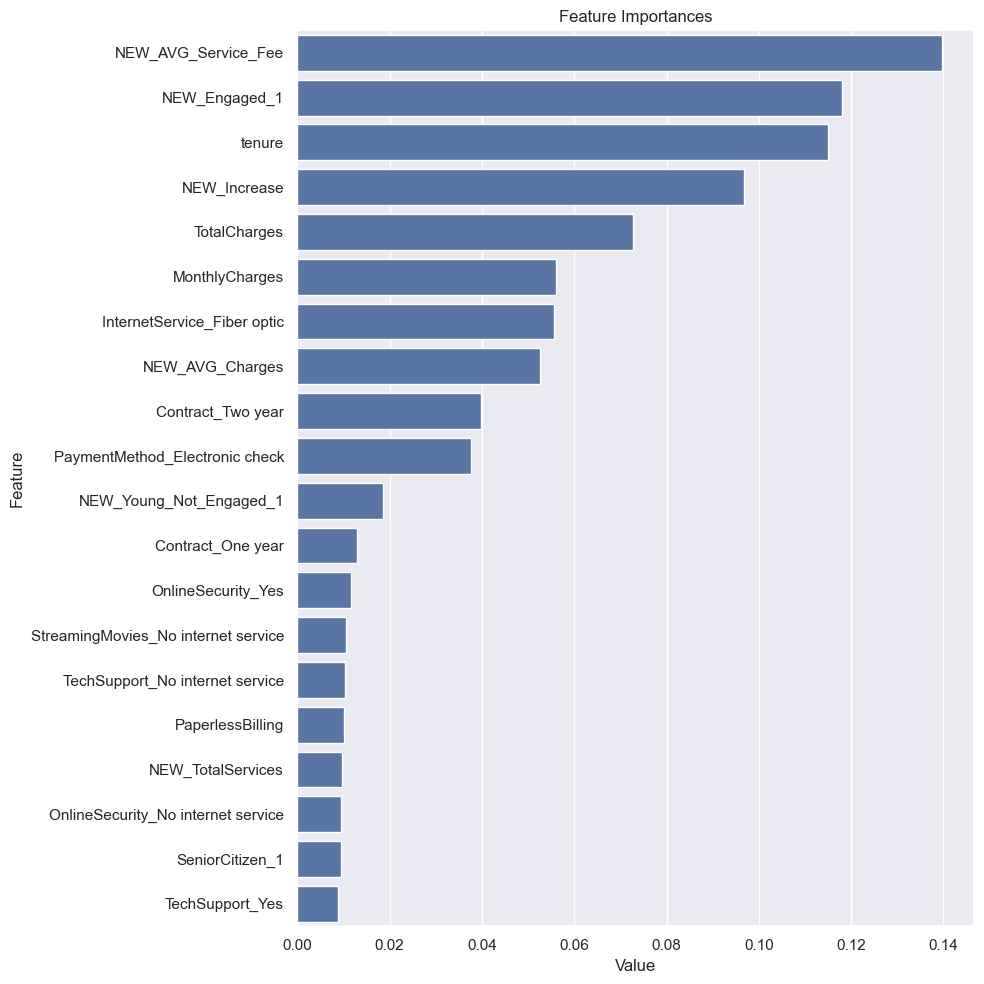

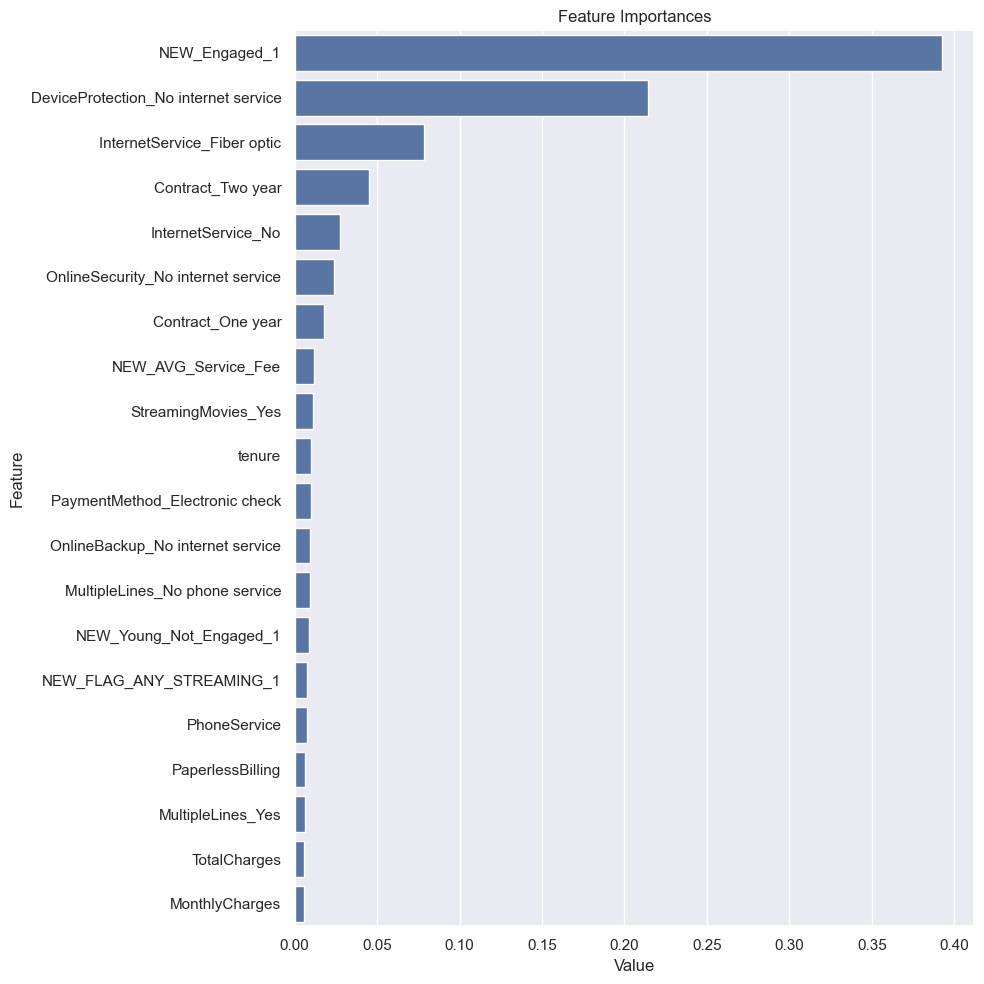

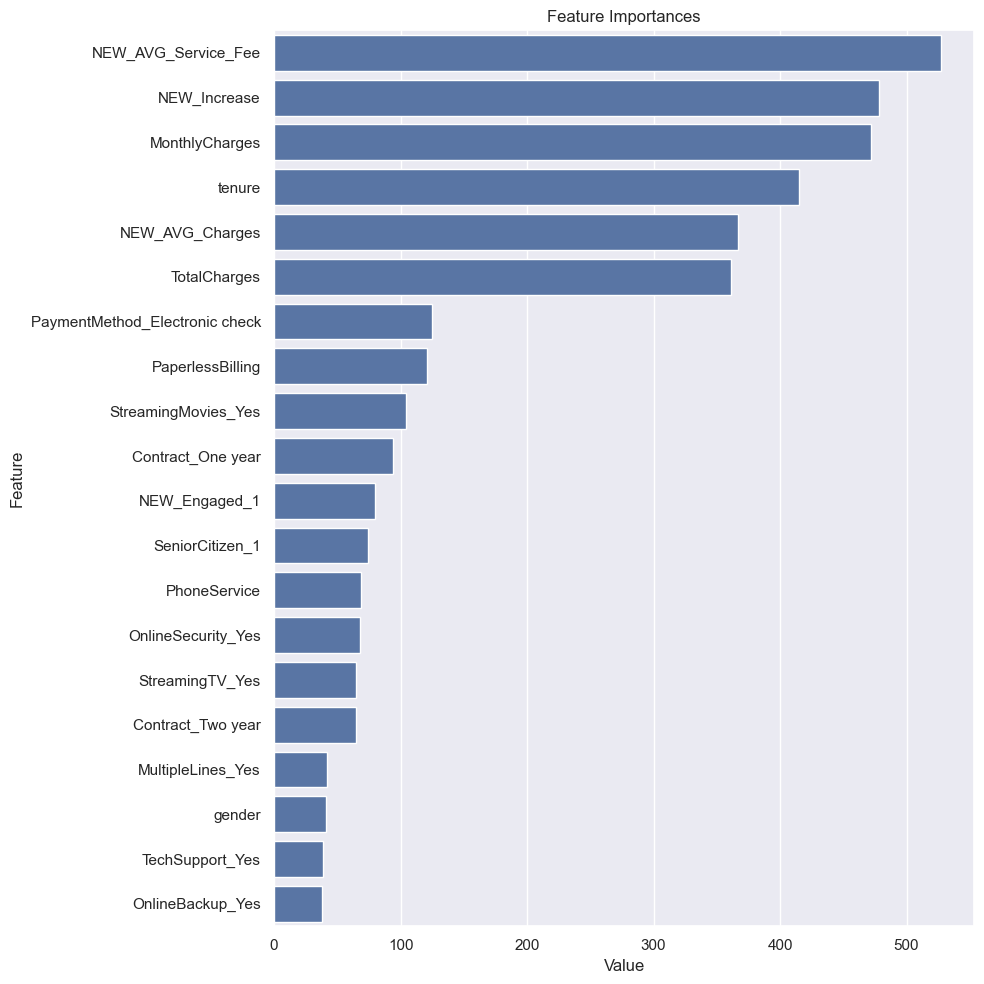

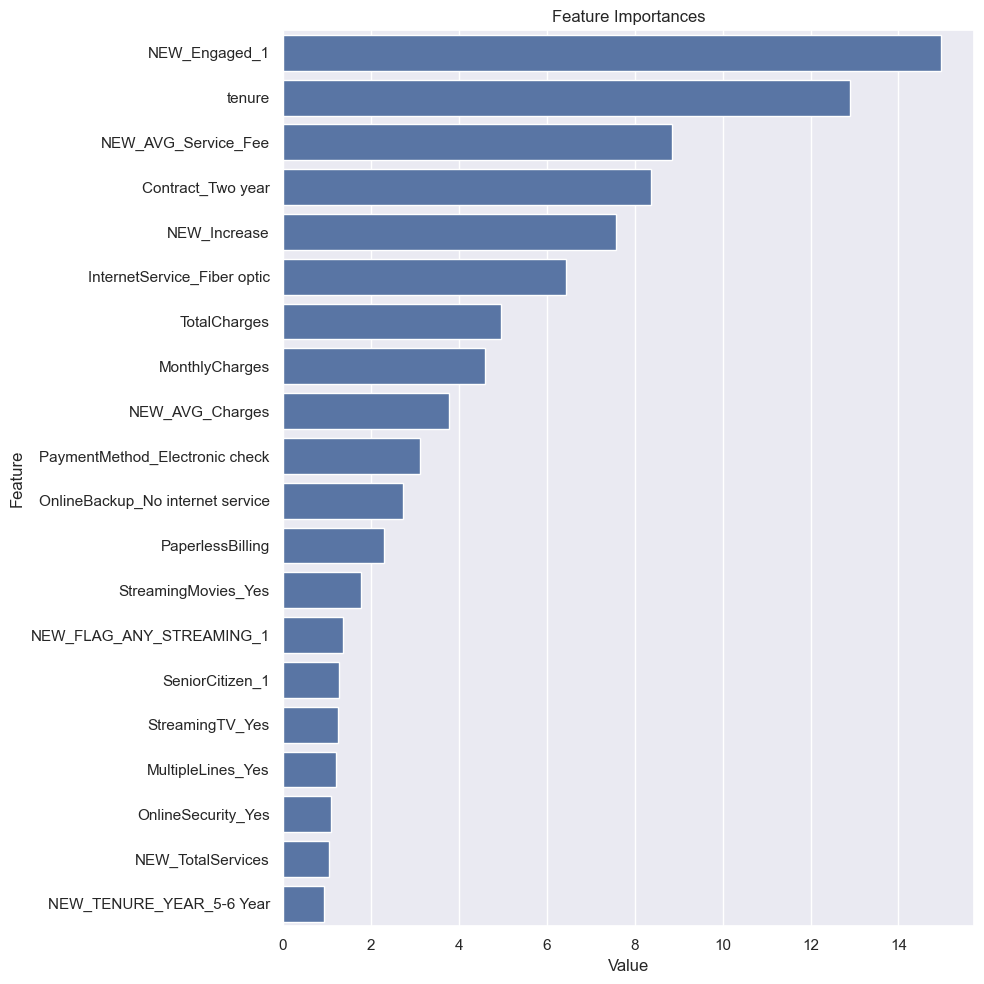

In [17]:
# %% Cell 17: Feature Importance
def plot_importance(model, features, num=20, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
plot_importance(xgb_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)

In [18]:
# %% Cell 18: Summary Report
print("### Telco Churn Prediction - Enhanced Project Summary ###")
print("1. Enhanced EDA with advanced visualizations including pair plots, violin plots, and custom-styled heatmaps.")
print("2. Implemented Optuna for hyperparameter tuning, replacing GridSearchCV.")
print("3. Added ensemble model (Voting Classifier) for improved performance.")
print("4. Structured code with cell-like sections for easy Jupyter notebook conversion.")
print("5. Best performing model based on AUC:", max(final_models, key=lambda x: cross_validate(x[1], X, y, cv=5, scoring="roc_auc")['test_score'].mean())[0])

### Telco Churn Prediction - Enhanced Project Summary ###
1. Enhanced EDA with advanced visualizations including pair plots, violin plots, and custom-styled heatmaps.
2. Implemented Optuna for hyperparameter tuning, replacing GridSearchCV.
3. Added ensemble model (Voting Classifier) for improved performance.
4. Structured code with cell-like sections for easy Jupyter notebook conversion.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] Found whitespace 